In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline
from pandas import datetime
import math, time
import itertools
from sklearn import preprocessing
import datetime
from operator import itemgetter
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
from keras.models import load_model
import keras
import h5py
import requests
import os

# Retornado a versao do np.__version__  #1.20.1 
# Mudei para '1.19.2' com o comando pip install numpy==1.19.2

/tmp/ipykernel_166580/1181035731.py:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime
2021-09-19 12:23:04.307334: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-09-19 12:23:04.307355: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
source_file = '../../../Data/Processed/cenario3/dados_cenario3.csv'
df_wind = pd.read_csv(source_file, delimiter=';', index_col=0, parse_dates=['Data'])
df_wind.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8808 entries, 0 to 8807
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Longitude        8808 non-null   float64       
 1   Latitude         8808 non-null   float64       
 2   Data             8808 non-null   datetime64[ns]
 3   Vento_Magnitude  8808 non-null   float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 344.1 KB


In [3]:
df_wind.isnull().sum()

Longitude          0
Latitude           0
Data               0
Vento_Magnitude    0
dtype: int64

import matplotlib.pyplot as plt
df_serietemporal = df_wind
df_serietemporal = df_serietemporal.drop(['Longitude', 'Latitude','Direcao','Pressao','Temperatura','Chuva'], axis=1)
df_serietemporal = df_serietemporal.set_index('Data')

df_serietemporal.plot(figsize=(12,5)) #,color='#4F4F4F' >> força uma cor para todo grafico
plt.xticks(rotation=45)
plt.xlabel('Data')
plt.ylabel('Vento PREVISTO-m/s')
plt.tight_layout()

In [4]:
df_serietemporal = df_wind
df_serietemporal['Date'] = df_serietemporal.index
df_serietemporal.head(2)

,Longitude,Latitude,Data,Vento_Magnitude,Date
0,-42.75,-14.25,2017-01-01 00:00:00,9.815,0
1,-42.75,-14.25,2017-01-01 01:00:00,8.735,1


In [5]:
df_serietemporal.tail(2) # Tail = mostra ps ultimos registros

,Longitude,Latitude,Data,Vento_Magnitude,Date
8806,-42.75,-14.25,2018-01-02 22:00:00,3.352,8806
8807,-42.75,-14.25,2018-01-02 23:00:00,5.190,8807


### LSTMs são sensíveis à escala dos dados de entrada, especificamente quando as funções de ativação sigmóide (padrão) ou tanh são usadas. Pode ser uma boa prática redimensionar os dados para o intervalo de 0 a 1, também chamado de normalização.

In [6]:
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
dataset = min_max_scaler.fit_transform(df_serietemporal['Vento_Magnitude'].values.reshape(-1, 1))

In [7]:
dataset[0:10]

array([[0.55909119],
       [0.49223055],
       [0.4748344 ],
       [0.51965579],
       [0.52015106],
       [0.53098496],
       [0.47167709],
       [0.40933573],
       [0.4362038 ],
       [0.40853092]])

### Dividir em conjuntos de treinamento e teste

In [8]:
# split into train and test sets
train_size = int(len(dataset) * 0.7)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

6165 2643


### Define-se a data de "look back" como 7 dias, que é o número de etapas de tempo anteriores para usar como variáveis de entrada para prever o próximo período de tempo

In [9]:
# Converter uma matriz de valores em uma matriz de conjunto de dados
def create_dataset(dataset, look_back=7):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [10]:
x_train, y_train = create_dataset(train, look_back=7)
x_test, y_test = create_dataset(test, look_back=7)

In [11]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(6157, 7)
(6157,)
(2635, 7)
(2635,)


### A rede LSTM espera que os dados de entrada (X) sejam fornecidos com uma estrutura de array específica na forma de: [amostras, intervalos de tempo, recursos]. Atualmente, esses dados estão no formato: [amostras, recursos] e estamos enquadrando o problema como uma etapa de tempo para cada amostra. <br>
### Podemos transformar o "treino" e os dados de entrada de teste na estrutura esperada usando numpy.reshape () da seguinte maneira:

In [12]:
x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))

In [13]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(6157, 1, 7)
(6157,)
(2635, 1, 7)
(2635,)


LSTM

A rede Long Short-Term Memory, ou rede LSTM, é uma rede neural recorrente que é treinada usando Backpropagation Through Time e supera o problema do gradiente de desaparecimento.

Como tal, ele pode ser usado para criar grandes redes recorrentes que, por sua vez, podem ser usadas para resolver problemas de sequência difíceis no aprendizado de máquina e obter resultados de última geração.

Em vez de neurônios, as redes LSTM têm blocos de memória que são conectados por meio de camadas.

Um bloco possui componentes que o tornam mais inteligente do que um neurônio clássico e uma memória para sequências recentes. Um bloco contém portas que gerenciam o estado e a saída do bloco. Um bloco opera em uma sequência de entrada e cada porta dentro de um bloco usa as unidades de ativação sigmóide para controlar se elas são disparadas ou não, tornando a mudança de estado e adição de informações que fluem através do bloco condicional.

Existem três tipos de portas dentro de uma unidade:
Forget Gate:Porta de entrada: decide condicionalmente quais valores da entrada atualizar o estado da memória.

Forget Gate: decide condicionalmente quais informações jogar fora do bloco.
Input Gate:: decide condicionalmente quais valores da entrada atualizar o estado da memória.
Output Gate: decide condicionalmente o que produzir com base na entrada e na memória do bloco.

Cada unidade é como uma mini-máquina de estados onde os portões das unidades possuem pesos que são aprendidos durante o procedimento de treinamento.

### A rede tem uma camada visível com 1 entrada, uma camada oculta com 20 blocos LSTM ou neurônios e uma camada de saída que faz uma previsão de 7 valores. A função de ativação sigmóide padrão é usada para os blocos LSTM. A rede é treinada para 20 épocas e um tamanho de lote de 1 é usado.

KERAS: Model.fit(epochs,verbose)
1.epochs: Inteiro. Número de épocas para treinar o modelo. Uma época é uma iteração sobre todos os dados x e y fornecidos. 
2.verbose: 'auto', 0, 1 ou 2. Modo de verbosidade. 0 = silencioso, 1 = barra de progresso, 2 = uma linha por época. 

In [14]:
# create and fit the LSTM network
look_back = 7
model = Sequential()
model.add(LSTM(20, input_shape=(1, look_back)))
model.add(Dense(1))
#model.compile(loss='mean_squared_error', optimizer='adam')
model.compile(loss='mse', optimizer='adam')

model.fit(x_train, y_train, epochs=20, batch_size=1, verbose=2)

# ** model = Sequential()
# ** model.add(Dense(2, init='uniform', input_dim=64))
# ** model.add(Activation('softmax'))
# ** model.compile(optimizer='sgd', loss='mse')

2021-09-19 12:26:43.140931: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-09-19 12:26:43.140983: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-09-19 12:26:43.141020: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (NB-MLS-UBUNTU): /proc/driver/nvidia/version does not exist
2021-09-19 12:26:43.141653: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-09-19 12:26:43.318984: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR 

Epoch 1/20
6157/6157 - 6s - loss: 0.0046
Epoch 2/20
6157/6157 - 5s - loss: 0.0034
Epoch 3/20
6157/6157 - 6s - loss: 0.0033
Epoch 4/20
6157/6157 - 6s - loss: 0.0032
Epoch 5/20
6157/6157 - 5s - loss: 0.0032
Epoch 6/20
6157/6157 - 5s - loss: 0.0032
Epoch 7/20
6157/6157 - 5s - loss: 0.0032
Epoch 8/20
6157/6157 - 5s - loss: 0.0031
Epoch 9/20
6157/6157 - 5s - loss: 0.0031
Epoch 10/20
6157/6157 - 7s - loss: 0.0031
Epoch 11/20
6157/6157 - 5s - loss: 0.0031
Epoch 12/20
6157/6157 - 5s - loss: 0.0031
Epoch 13/20
6157/6157 - 5s - loss: 0.0031
Epoch 14/20
6157/6157 - 6s - loss: 0.0031
Epoch 15/20
6157/6157 - 5s - loss: 0.0031
Epoch 16/20
6157/6157 - 6s - loss: 0.0031
Epoch 17/20
6157/6157 - 5s - loss: 0.0031
Epoch 18/20
6157/6157 - 5s - loss: 0.0031
Epoch 19/20
6157/6157 - 5s - loss: 0.0031
Epoch 20/20
6157/6157 - 6s - loss: 0.0030


In [15]:
trainPredict = model.predict(x_train)
testPredict = model.predict(x_test)
# invert predictions
trainPredict = min_max_scaler.inverse_transform(trainPredict)
trainY = min_max_scaler.inverse_transform([y_train])
testPredict = min_max_scaler.inverse_transform(testPredict)
testY = min_max_scaler.inverse_transform([y_test])


# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))

testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.92 RMSE
Test Score: 0.94 RMSE


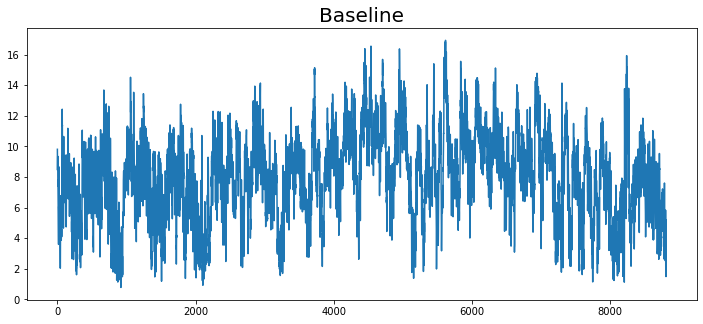

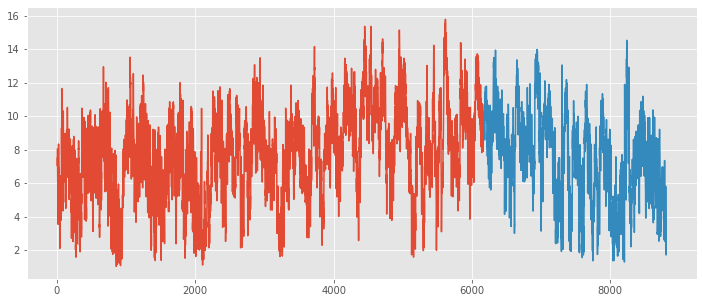

In [16]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# plot baseline and predictions
plt.figure(figsize=(12, 5))
plt.title(f'Baseline', fontsize=20)
plt.plot(min_max_scaler.inverse_transform(dataset))

#plt.title(f'Predicao do Treino e Teste', fontsize=20)
plt.figure(figsize=(12, 5))
plt.style.use('ggplot')
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)

plt.show()

